In [2]:
!brew install graphviz

zsh:1: command not found: brew


In [155]:
# Import libraries that will be needed for the lab
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.cluster import KMeans

from tensorflow.keras import optimizers
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Dense, Dropout
#from tensorflow.python.keras.utils import plot_model

import pickle

import random
random.seed(123)
data_path = '/Users/KKum25/Downloads/kddcup.data.corrected'

In [156]:
#data_path = 

col_names = ["duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins","logged_in",
             "num_compromised","root_shell","su_attempted","num_root","num_file_creations","num_shells","num_access_files","num_outbound_cmds",
             "is_host_login","is_guest_login","count","srv_count","serror_rate","srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
             "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count","dst_host_same_srv_rate","dst_host_diff_srv_rate",
             "dst_host_same_src_port_rate","dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate","dst_host_rerror_rate",
             "dst_host_srv_rerror_rate","label"]

df =  pd.read_csv(data_path, header=None, names=col_names, index_col=False)

le = LabelEncoder()
le.fit(df.label)
pct_anomalies=.01
df

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,215,45076,0,0,0,0,...,0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,normal.
1,0,tcp,http,SF,162,4528,0,0,0,0,...,1,1.0,0.0,1.00,0.00,0.0,0.00,0.0,0.0,normal.
2,0,tcp,http,SF,236,1228,0,0,0,0,...,2,1.0,0.0,0.50,0.00,0.0,0.00,0.0,0.0,normal.
3,0,tcp,http,SF,233,2032,0,0,0,0,...,3,1.0,0.0,0.33,0.00,0.0,0.00,0.0,0.0,normal.
4,0,tcp,http,SF,239,486,0,0,0,0,...,4,1.0,0.0,0.25,0.00,0.0,0.00,0.0,0.0,normal.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4898426,0,tcp,http,SF,212,2288,0,0,0,0,...,255,1.0,0.0,0.33,0.05,0.0,0.01,0.0,0.0,normal.
4898427,0,tcp,http,SF,219,236,0,0,0,0,...,255,1.0,0.0,0.25,0.05,0.0,0.01,0.0,0.0,normal.
4898428,0,tcp,http,SF,218,3610,0,0,0,0,...,255,1.0,0.0,0.20,0.05,0.0,0.01,0.0,0.0,normal.
4898429,0,tcp,http,SF,219,1234,0,0,0,0,...,255,1.0,0.0,0.17,0.05,0.0,0.01,0.0,0.0,normal.


In [157]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import argparse
import pickle
def reduce_anomalies(df, pct_anomalies=.01):
    labels = df['label'].copy()
    is_anomaly = labels != 'normal.'
    print(is_anomaly)
    num_normal = np.sum(~is_anomaly)
    num_anomalies = int(pct_anomalies * num_normal)
    all_anomalies = labels[labels != 'normal.']
    anomalies_to_keep = np.random.choice(all_anomalies.index, size=num_anomalies, replace=False)
    anomalous_data = df.iloc[anomalies_to_keep].copy()
    normal_data = df[~is_anomaly].copy()
    new_df = pd.concat([normal_data, anomalous_data], axis=0)
    return new_df

df = reduce_anomalies(df, pct_anomalies=pct_anomalies)

# capture the categorical variables and one-hot encode them
cat_vars = ['protocol_type', 'service', 'flag', 'land', 'logged_in','is_host_login', 'is_guest_login']

# find unique labels for each category
cat_data = pd.get_dummies(df[cat_vars])

numeric_vars = list(set(df.columns.values.tolist()) - set(cat_vars))
numeric_vars.remove('label')
numeric_data = df[numeric_vars].copy()

numeric_cat_data = pd.concat([numeric_data, cat_data], axis=1)

# capture the labels
labels = df['label'].copy()

# convert labels to integers
integer_labels = le.transform(labels)

# split data into test and train
x_train, x_test, y_train, y_test = train_test_split(numeric_cat_data,
                                                    integer_labels,
                                                    test_size=.25, 
                                                    random_state=42)

# save the datasets for later use
preprocessed_data = {
    'x_train':x_train,
    'y_train':y_train,
    'x_test':x_test,
    'y_test':y_test,
    'le':le
}

# pickle the preprocessed_data
print("writing to file")
path = 'preprocessed_data_full.pkl'
out = open(path, 'wb')
pickle.dump(preprocessed_data, out)
out.close()

0          False
1          False
2          False
3          False
4          False
           ...  
4898426    False
4898427    False
4898428    False
4898429    False
4898430    False
Name: label, Length: 4898431, dtype: bool
writing to file


In [158]:
pct_anomalies =.01

In [159]:
#!python preprocess_data.py --pct_anomalies $pct_anomalies

In [160]:
filename =  './preprocessed_data_full.pkl'
input_file = open(filename,'rb')
preprocessed_data = pickle.load(input_file)
input_file.close()

In [161]:
type(preprocessed_data)

dict

In [162]:
for k in preprocessed_data:
    print(k)

x_train
y_train
x_test
y_test
le


In [163]:
x_train= preprocessed_data['x_train']
y_train= preprocessed_data['y_train']
x_test= preprocessed_data['x_test']
le= preprocessed_data['le']


In [164]:
x_train

,duration,dst_host_srv_count,diff_srv_rate,same_srv_rate,dst_host_rerror_rate,srv_diff_host_rate,num_access_files,dst_host_serror_rate,dst_host_count,count,...,flag_OTH,flag_REJ,flag_RSTO,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
36292,0,220,0.0,1.0,0.0,0.50,0,0.0,220,4,...,0,0,0,0,0,0,0,0,1,0
811334,0,90,0.0,1.0,0.0,0.00,0,0.0,142,1,...,0,0,0,0,0,0,0,0,1,0
4496690,0,222,0.0,1.0,0.0,0.00,0,0.0,255,1,...,0,0,0,0,0,0,0,0,1,0
36337,0,255,0.0,1.0,0.0,0.00,0,0.0,3,3,...,0,0,0,0,0,0,0,0,1,0
4895936,0,255,0.0,1.0,0.0,0.12,0,0.0,255,13,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297406,0,255,0.0,1.0,0.0,0.29,0,0.0,5,3,...,0,0,0,0,0,0,0,0,1,0
405072,0,39,0.0,1.0,1.0,1.00,0,0.0,39,1,...,0,1,0,0,0,0,0,0,0,0
168916,0,255,0.0,1.0,0.0,0.60,0,0.0,12,3,...,0,0,0,0,0,0,0,0,1,0
1418760,30,42,0.0,1.0,0.0,0.00,0,0.0,161,1,...,0,0,0,0,0,0,0,0,1,0


In [165]:
le.classes_

array(['back.', 'buffer_overflow.', 'ftp_write.', 'guess_passwd.',
       'imap.', 'ipsweep.', 'land.', 'loadmodule.', 'multihop.',
       'neptune.', 'nmap.', 'normal.', 'perl.', 'phf.', 'pod.',
       'portsweep.', 'rootkit.', 'satan.', 'smurf.', 'spy.', 'teardrop.',
       'warezclient.', 'warezmaster.'], dtype=object)

In [166]:
scaler = MinMaxScaler()
x_train= scaler.fit_transform(x_train)
x_test=scaler.transform(x_test)


In [167]:
x_train

array([[0.00000000e+00, 8.62745098e-01, 0.00000000e+00, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 3.52941176e-01, 0.00000000e+00, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 8.70588235e-01, 0.00000000e+00, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 1.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [8.34678092e-04, 1.64705882e-01, 0.00000000e+00, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00]])

In [168]:
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

In [169]:
x_train.shape[0]

736881

In [170]:
batch_size = 512
epoch_size= 10
latent_dim= 4
input_dim = x_train.shape[1]

In [171]:
#input_data = Input(shape=(input_dim,),name='encoder_input')
input_data = Input(shape=(input_dim,), name='encoder_input')
encoder = Dense(94,activation='tanh', name='encoder1')(input_data)
encoder = Dropout(.1)(encoder)
encoder = Dense(64,activation='tanh', name='encoder2')(encoder)
encoder = Dropout(.1)(encoder)
encoder = Dense(46,activation='tanh', name='encoder3')(encoder)
encoder = Dropout(.1)(encoder)
encoder = Dense(16,activation='tanh', name='encoder4')(encoder)
encoder = Dropout(.1)(encoder)
latent_encoding = Dense (latent_dim, activation='linear',name='latent_encoding')(encoder)


In [172]:
encoder_model = Model(input_data,latent_encoding)

In [173]:
encoder_model.summary()

Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 115)]             0         
_________________________________________________________________
encoder1 (Dense)             (None, 94)                10904     
_________________________________________________________________
dropout_36 (Dropout)         (None, 94)                0         
_________________________________________________________________
encoder2 (Dense)             (None, 64)                6080      
_________________________________________________________________
dropout_37 (Dropout)         (None, 64)                0         
_________________________________________________________________
encoder3 (Dense)             (None, 46)                2990      
_________________________________________________________________
dropout_38 (Dropout)         (None, 46)              

In [174]:
decoder = Dense(16, activation='tanh',name='decoder-1')(latent_encoding)
decoder = Dropout(.1)(decoder)
decoder = Dense(46, activation='tanh',name='decoder-2')(decoder)
decoder = Dropout(.1)(decoder)
decoder = Dense(64, activation='tanh',name='decoder-3')(decoder)
decoder = Dropout(.1)(decoder)
decoder = Dense(94, activation='tanh',name='decoder-4')(decoder)
decoder = Dropout(.1)(decoder)
reconstructed_data = Dense(input_dim,activation='linear',name='recconstruct_data')(decoder)
ae_model= Model(input_data,reconstructed_data)
ae_model.summary()

Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 115)]             0         
_________________________________________________________________
encoder1 (Dense)             (None, 94)                10904     
_________________________________________________________________
dropout_36 (Dropout)         (None, 94)                0         
_________________________________________________________________
encoder2 (Dense)             (None, 64)                6080      
_________________________________________________________________
dropout_37 (Dropout)         (None, 64)                0         
_________________________________________________________________
encoder3 (Dense)             (None, 46)                2990      
_________________________________________________________________
dropout_38 (Dropout)         (None, 46)              

In [175]:
opt= optimizers.Adam(lr=.00001)
ae_model.compile(optimizer=opt,loss='mse')

In [176]:
train_history = ae_model.fit(x_train, x_train,
        shuffle=True,
        epochs=epoch_size,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

Epoch 1/10
1440/1440 [==============================] - 7s 5ms/step - loss: 0.0556 - val_loss: 0.0188
Epoch 2/10
1440/1440 [==============================] - 7s 5ms/step - loss: 0.0270 - val_loss: 0.0126
Epoch 3/10
1440/1440 [==============================] - 7s 5ms/step - loss: 0.0193 - val_loss: 0.0104
Epoch 4/10
1440/1440 [==============================] - 7s 5ms/step - loss: 0.0149 - val_loss: 0.0086
Epoch 5/10
1440/1440 [==============================] - 7s 5ms/step - loss: 0.0120 - val_loss: 0.0067
Epoch 6/10
1440/1440 [==============================] - 7s 5ms/step - loss: 0.0099 - val_loss: 0.0054
Epoch 7/10
1440/1440 [==============================] - 8s 5ms/step - loss: 0.0085 - val_loss: 0.0050
Epoch 8/10
1440/1440 [==============================] - 7s 5ms/step - loss: 0.0078 - val_loss: 0.0048
Epoch 9/10
1440/1440 [==============================] - 8s 5ms/step - loss: 0.0073 - val_loss: 0.0048
Epoch 10/10
1440/1440 [==============================] - 8s 5ms/step - loss: 0.007

In [178]:
train_history.history

{'loss': [0.05556555092334747,
  0.026952272281050682,
  0.019283227622509003,
  0.014922534115612507,
  0.012024173513054848,
  0.009851498529314995,
  0.008502337150275707,
  0.007793319411575794,
  0.0073207663372159,
  0.006992388516664505],
 'val_loss': [0.018841292709112167,
  0.012615089304745197,
  0.010389133356511593,
  0.008635039441287518,
  0.006736712530255318,
  0.005359342787414789,
  0.004962237551808357,
  0.004837976768612862,
  0.004769987892359495,
  0.004731612745672464]}

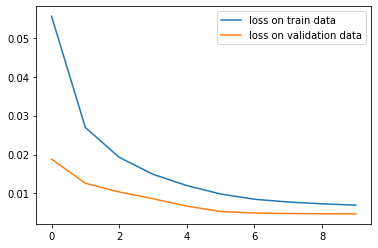

In [179]:
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.legend(['loss on train data', 'loss on validation data'])

In [209]:
test = x_test[1,114]
test = ae_model.predict(test)
recon_data = ae_model.predict(test)
reconstruction_scores1 = np.mean((test - recon_data)**2, axis=1)

ValueError: Failed to find data adapter that can handle input: <class 'numpy.float32'>, <class 'NoneType'>

In [218]:
test = x_test[1,0:115]
test1=np.reshape(test, (1,115))
test1.shape
test = ae_model.predict(test1)
recon_data = ae_model.predict(test)
reconstruction_scores1 = np.mean((test - recon_data)**2, axis=1)


In [219]:
reconstruction_scores1

array([6.2301e-05], dtype=float32)

In [128]:
anamoly_data= pd.DataFrame({'rec_error':reconstruction_scores})

<AxesSubplot:xlabel='Reconstruction Score', ylabel='Frequency'>

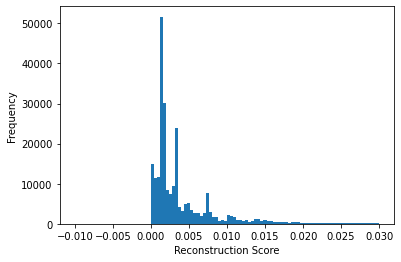

In [129]:
plt.xlabel('Reconstruction Score')
anamoly_data['rec_error'].plot.hist(bins=100, range=[-.01, .03])

In [130]:
type(x_test)

numpy.ndarray

In [131]:
x_test.shape

(245627, 113)

In [132]:
anamoly_data.shape

(245627, 1)

In [133]:
def convert_label_binary(le,label):
    normal_indx=np.where(le.classes_ == 'normal.')[0][0]
    my_labels = label.copy()
    my_labels[my_labels!=normal_indx]=1
    my_labels[my_labels==normal_indx]=0
    return my_labels
    

In [134]:
# convert our labels to binary
binary_labels = convert_label_binary(le, y_test)

# add the binary labels to our anomaly dataframe
anamoly_data['binary_labels'] = binary_labels

# let's check if the reconstruction statistics are different for labeled anomalies
anamoly_data.groupby(by='binary_labels').describe()

rec_error                                                    \
                  count      mean       std       min       25%       50%   
binary_labels                                                               
0              243161.0  0.004341  0.006244  0.000056  0.001575  0.002050   
1                2466.0  0.053315  0.044425  0.010255  0.046585  0.046585   

                                   
                    75%       max  
binary_labels                      
0              0.004923  1.473731  
1              0.046585  2.163403

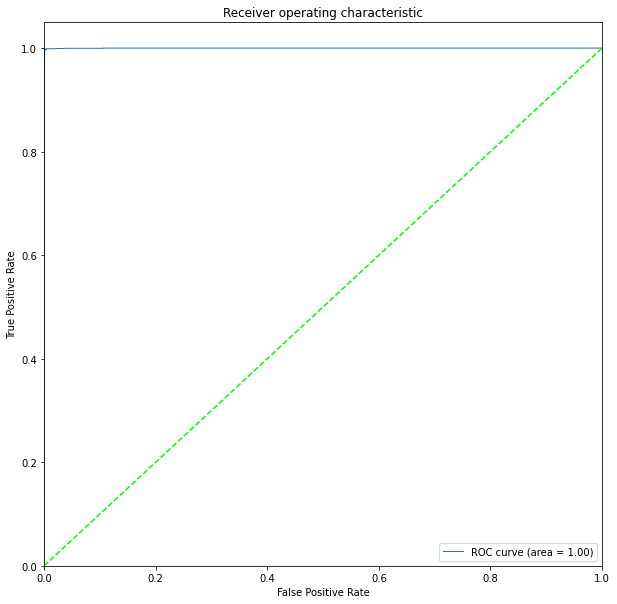

In [135]:
fpr, tpr, thresholds = roc_curve(binary_labels, reconstruction_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='lime', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [136]:
recon_mean = np.mean(reconstruction_scores)
recon_stddev = np.std(reconstruction_scores)

stats_threshold = recon_mean + 5*recon_stddev
print(stats_threshold)
thresh = stats_threshold



print(thresh)

pred_labels = (reconstruction_scores > thresh).astype(int)

results = confusion_matrix(binary_labels, pred_labels)

0.05017544748261571
0.05017544748261571


In [137]:
#reconstruction_scores=([1,2,3,3])
#pred_labels = (reconstruction_scores < thresh).astype(int)
#pred_labels.astype('bool')

Confusion Matrix: 


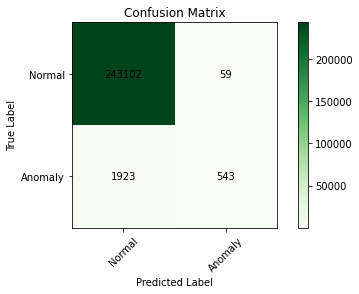

In [138]:
print ('Confusion Matrix: ')

def plot_confusion_matrix(cm, target_names, title='Confusion Matrix', cmap=plt.cm.Greens):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()

    width, height = cm.shape

    for x in range(width):
        for y in range(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')


plot_confusion_matrix(results, ['Normal','Anomaly'])

In [139]:
x_test_df = pd.DataFrame(x_test)

test_anomalies = x_test_df[pred_labels.astype('bool')]

In [140]:
pred_labels.astype('bool')

array([False, False, False, ..., False, False, False])

In [141]:
x_test_df = pd.DataFrame(x_test)

test_anomalies = x_test_df[pred_labels.astype('bool')]

y_test_df = pd.DataFrame(y_test)
test_anomalies_labels = y_test_df[pred_labels.astype('bool')]

In [142]:
test_anomalies_labels

,0
276,9
668,9
1240,9
1931,11
2144,11
...,...
244243,9
244544,9
244658,11
244772,9


In [143]:
x_test_df = pd.DataFrame(x_test)

test_anomalies = x_test_df[pred_labels.astype('bool')]

y_test_df = pd.DataFrame(y_test)
test_anomalies_labels = y_test_df[pred_labels.astype('bool')]

# encode the test anomalies into latent space
encoded_test_anomalies = encoder_model.predict(test_anomalies)

In [153]:
print(kmeans.labels_.shape)
print(x_test.shape)
print(test_anomalies.shape)
print(test_anomalies_labels.shape)

(602,)
(245627, 113)
(602, 113)
(602, 1)


In [144]:
kmeans = KMeans(n_clusters=10, random_state=123)
kmeans.fit(encoded_test_anomalies)

KMeans(n_clusters=10, random_state=123)

In [145]:
clusters = pd.DataFrame({'cluster':kmeans.labels_, 'label':test_anomalies_labels[0]})

most_frequent_labels = clusters.groupby('cluster').label.value_counts()

print(most_frequent_labels)

cluster  label
0        11        18
         9          1
1        9        496
         11         2
2        17         9
         15         1
3        11        11
4        11         5
5        9         30
         11         6
6        11         8
7        11         3
8        11         5
         9          1
         15         1
9        9          4
         11         1
Name: label, dtype: int64


In [146]:
cluster_to_label = {}
for cluster in range(0, 10):
    label = most_frequent_labels[cluster].index[0]
    cluster_to_label[cluster] = label

# we then replace the clusters inplace by their label values
clusters.cluster.replace(cluster_to_label, inplace=True)

Confusion Matrix :


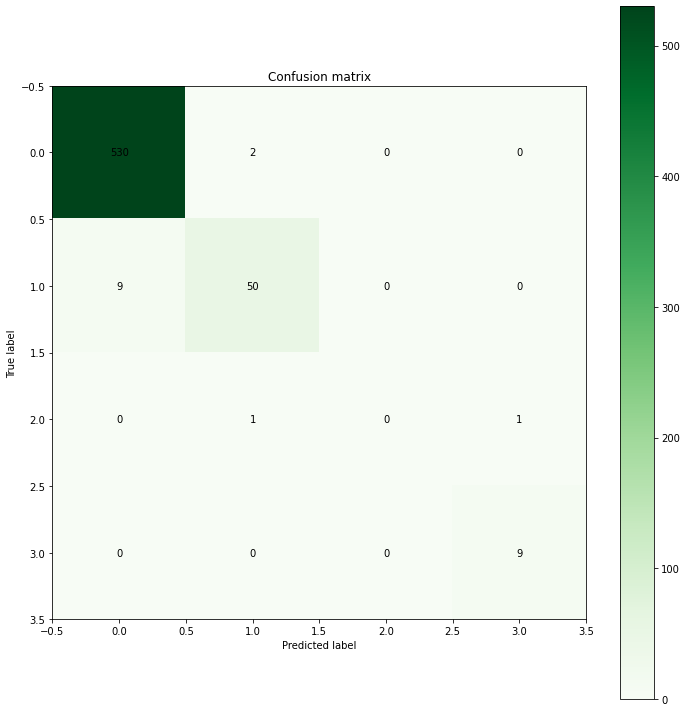

In [147]:
cm = confusion_matrix(clusters.label, clusters.cluster)

print ('Confusion Matrix :')

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Greens):
    plt.figure(figsize=(10,10),)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()

    width, height = cm.shape

    for x in range(width):
        for y in range(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


plot_confusion_matrix(cm)

In [148]:
type(test_anomalies_labels)

pandas.core.frame.DataFrame